### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2022 Semester 2

## Assignment 1

**Student Name:**    Yvonne Tao

**Student ID:**     1183577

This iPython notebook is a template which you should use for your Assignment 3 submission. This file should be submitted at the **Assignment 3: Code** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a writren report explaining your results at the **Assignment 3: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 1. Load images and compute correspondences


In [217]:
import glob
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from sys import flags
import scipy.io
import math
import random


In [218]:
rootpath = "./kusvod2"
img_paths = sorted(glob.glob( rootpath + '/*'))
imageA_paths = []
imagesB_paths = []
vpts_mat_paths = []

# read all images under kusvod2, save them to corresponding path lists
for path in img_paths:
    
    if((path.endswith('A.jpg')) or (path.endswith('A.png'))):
        imageA_paths.append(path)
    if((path.endswith('B.jpg')) or (path.endswith('B.png'))):
        imagesB_paths.append(path)
    if(path.endswith('.mat')):
        vpts_mat_paths.append(path)

In [219]:
#show images in RGB order
def imshow(image, *args, **kwargs):
    print('Image shape:',image.shape)
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion since 
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
      # Height, width - must be grayscale
      # convert to RGB, since matplotlib will plot in a weird colormap (instead of black = 0, white = 1)
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Draw the image
    plt.imshow(image, *args, **kwargs)
    plt.axis('off')
    # Make sure it outputs
    plt.show()

### 2. Compute the Fundamental Matrix F using the 8 point algorithm

In [220]:
def findKeyPointsAndReturnMatch(img1,img2):

    # Initiate SIFT detector
    sift = cv2.SIFT_create() # if cv2 version >= 4.4.0 

    # use BFmatcher, use crossCheck good alternative to ratio test proposed by D.Lowe in SIFT paper
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck = True)

    # Compute SIFT keypoints and descriptors
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)

    matches = bf.match(descriptors_1,descriptors_2)
    matches = sorted(matches, key = lambda x:x.distance)[:300]

    img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches, img2, flags=2)
    plt.imshow(img3),plt.show()
    
    ptsL = []
    ptsR = []
    for item in matches:
        ptsL.append(keypoints_1[item.queryIdx].pt)
        ptsR.append(keypoints_2[item.trainIdx].pt)

    ptsL = np.int32(ptsL)
    ptsR = np.int32(ptsR)
    return ptsL,ptsR, matches

In [221]:
def  findKeyPointsAndReturnMatch_Flann(img1,img2):
    # Initiate SIFT detector
    sift = cv2.SIFT_create() # if cv2 version >= 4.4.0 
    # sift = cv2.xfeatures2d.SIFT_create() # if cv2 version = 4.3.x

    # Compute SIFT keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN parameters and initialize
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Matching descriptor using KNN algorithm
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply ratio test
    ptsL = []
    ptsR = []

    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8 * n.distance: # was 0.7
            ptsL.append(kp1[m.queryIdx].pt)
            ptsR.append(kp2[m.trainIdx].pt)

    ptsL = np.int32(ptsL)
    ptsR = np.int32(ptsR)
    return ptsL,ptsR, matches

In [222]:
# a function to draw epilines over the images
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines, pts1, pts2):
    
        pt1 = np.array(pt1).astype(int)
        pt2 = np.array(pt2).astype(int)

        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1,img2


In [223]:
def findFundamentalMatrixTesting(pts1, pts2):

    F, mask = cv2.findFundamentalMat(pts1, pts2,cv2.FM_LMEDS)
    # Select only inlier points
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]

    # return the fundamental matrix
    return F,pts1, pts2

In [224]:
def find_dist_to_epiline(line, x0, y0):
    """ find an intercept point of the line model with
        a normal from point (x0,y0) to it, return
        distance betwee point (x0, y0) and intercept
    :param m slope of the line model
    :param c y-intercept of the line model
    :param x0 point's x coordinate
    :param y0 point's y coordinate
    :return intercept point
    """
    a,b,c = line
    
    # ax+by+c=0  => y = kx+ b
    k = - a / b
    bb = - c / b
    # intersection point with the model
    x = (x0 + k*y0 - k*bb)/(1 + k**2)
    y = (k*x0 + (k**2)*y0 - (k**2)*bb)/(1 + k**2) + bb
    dist = math.sqrt((x - x0)**2 + (y - y0)**2)
 
    return dist

In [225]:
def findFundamentalMatrix(points_A,points_B):
    
    # compute the design matrix
    a = np.zeros((8, 9))
    for i in range(8):
        p1 = points_B[i][0]
        p2 = points_B[i][1]
        q1 = points_A[i][0]
        q2 = points_A[i][1]
        a[i][0] = p1 * q1
        a[i][1] = p2 * q1
        a[i][2] = q1
        a[i][3] = p1 * q2
        a[i][4] = p2 * q2
        a[i][5] = q2
        a[i][6] = p1
        a[i][7] = p2
        a[i][8] = 1.0

    # perform SVD on the design matrix
    _,_,vh = np.linalg.svd(a)

    # transpose to fundamental matric F
    f_vec = vh.transpose()[:,8]
    # print("f_vec = ", f_vec)
    f_hat = np.reshape(f_vec, (3,3))
    # print("f_hat = ", f_hat)

    # perform SVD on the F - check rank is 2
    s,v,d = np.linalg.svd(f_hat)
    f_hat = s @ np.diag([*v[:2], 0]) @ d
    # print("f_hat = ", f_hat)
    return f_hat

In [226]:
def normalize_coordinates(coordinates,height,width):
    centerX = width/2
    centerY = height/2
   
    shiftingFactor = -1
    T = np.array([
        [1/centerX, 0, shiftingFactor], 
        [0, 1/centerY, shiftingFactor], 
        [0, 0, 1]])

    normalized_matrix = [T @ [x,y,1] for x,y in coordinates]
    normalized_coordinates = [[e[0],e[1]] for e in normalized_matrix]
    return normalized_coordinates, T


In [227]:
# denormalize to the original coordinates
def denormalize(f,T1,T2):
    f_mat = T2.transpose() @ f @ T1
    return f_mat


### 3. Randomly sample 10 correspondences and display images, corresponding points and epipolar lines

./kusvod2/KyotoA.jpg ./kusvod2/KyotoB.jpg ./kusvod2/Kyoto_vpts.mat
Image shape: (1944, 2592)


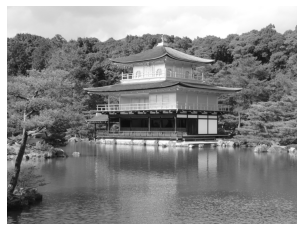

Image shape: (1944, 2592)


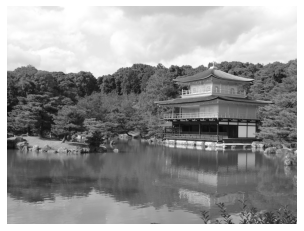

-----------------Testing------------

[[-5.04546476e-09 -6.74767154e-08  1.45357604e-04]
 [ 2.41272570e-07  4.56590113e-08 -3.32508408e-03]
 [-2.72071843e-04  2.36074633e-03  1.00000000e+00]]
inlier ratio of current loop  8.0
inlier ratio record  8.0
Eight points are =  [[0.8526234567901234, -0.3641975308641975], [0.5540123456790123, 0.2870370370370372], [0.10879629629629628, 0.039094650205761416], [0.49151234567901225, -0.3960905349794238], [0.4760802469135801, -0.38991769547325095], [0.3055555555555556, 0.19341563786008242], [0.4961419753086418, 0.4711934156378601], [0.25077160493827155, -0.3086419753086419]]


In [228]:
# start point - main

# interate through each pair
# TODO: delete [:4] for full set of images
for pathA,pathB,pathMat in zip(imageA_paths[:1], imagesB_paths[:1],vpts_mat_paths[:1]):
    print(pathA,pathB,pathMat)

    # Read in images from a filepath as graycsale.
    imageA = cv2.imread(pathA,cv2.IMREAD_GRAYSCALE)
    imageB = cv2.imread(pathB,cv2.IMREAD_GRAYSCALE)
    # mat = scipy.io.loadmat(pathMat)
    # mat = np.array(mat)

    # Display the images
    imshow(imageA)
    imshow(imageB)
    # print("Ground Truth Mat:", mat)

    # find matching keypoints using SIFT BF match
    # TODO: compare the method
    ptsA, ptsB, matches= findKeyPointsAndReturnMatch_Flann(imageA,imageB)
 
    #testing
    # TODO: delete
    F_testing, pts1_testing, pts2_testing = findFundamentalMatrixTesting(ptsA,ptsB)
    print("-----------------Testing------------\n")
    print(F_testing)


    # shift & scale keypoints using MinMax so that the centroid point is at the coordinates center, range within[-1,1]
    (height,width) = imageA.shape
    normlized_ptsA, T1 = normalize_coordinates(ptsA,height,width)
    normlized_ptsB, T2 = normalize_coordinates(ptsB,height,width)
    
    # Ransac parameters
    # TODO: design a function to get this number ransac_iterations
    ransac_iterations = 30  # number of iterations
    ransac_threshold = 20    # threshold
   
    # for keeping highest performance
    ratio = 0
    best_inliers = []
    # Find the least error fundamental matrix using RANSAC algorithm, with normalized coordinate
    for i in range(ransac_iterations):
        
        # randomly select 8 point from normalized data
        indexes = random.choices(range(len(normlized_ptsA)), k=8)
        points_selectedA = []
        points_selectedB = []
        for index in range(8):
            random_index = indexes[index]
            points_selectedA.append(normlized_ptsA[random_index])
            points_selectedB.append(normlized_ptsB[random_index])
        
        f_hat = findFundamentalMatrix(points_selectedA,points_selectedB)
        f_hat_denormalized = denormalize(f_hat,T1,T2)
        print("f_hat_denormalized",f_hat_denormalized)

        # get Epipolar lines in imageB
        linesOnR =  cv2.computeCorrespondEpilines(np.array(points_selectedA), 1, f_hat_denormalized)
        linesOnR = linesOnR.reshape(-1,3)

        # calculate inliners and outliner
        inliears = []
        num = 0
        centerX = width/2
        centerY = height/2
        # TODO: now.... 
        points_selectedA_unscaled = [[x *centerX+ centerX, y*centerY+centerY] for x,y in points_selectedA]
        points_selectedB_unscaled = [[x *centerX+ centerX, y*centerY+centerY] for x,y in points_selectedB]

        for p in normlized_ptsB:
            x = p[0]
            y = p[1]
            for line in linesOnR:
                dist = find_dist_to_epiline(line, x, y)

                # check whether it's an inlier or not
                # if dist < ransac_threshold:
                    # print("find one!")
                inliears.append(p)
                num += 1

                # plot
                drawlines(imageB,imageA,linesOnR,points_selectedA_unscaled,points_selectedB_unscaled)
        
        # if this value of num is higher than previously saved value,
        # save it, and save the current model parameters
        if num/ len(normlized_ptsB) > ratio:
            # break record, update 
            ratio = num/ len(normlized_ptsB)
            best_inliers = inliears
        
        print('inlier ratio of current loop ', num/len(normlized_ptsB))
        print('inlier ratio record ', ratio)
        print('Eight points are = ', points_selectedB)
       
        

        


        